<a href="https://colab.research.google.com/github/nredick/mais-hacks-2021/blob/main/src/poem_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/nredick/mais-hacks-2021/textgen/data/poemdataset/_sortedpoems.txt

--2021-10-03 13:30:45--  https://raw.githubusercontent.com/nredick/mais-hacks-2021/textgen/data/poemdataset/_sortedpoems.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45262200 (43M) [text/plain]
Saving to: ‘_sortedpoems.txt.4’

_sortedpoems.txt.4  100%[===================>]  43.17M   153MB/s    in 0.3s    

2021-10-03 13:30:46 (153 MB/s) - ‘_sortedpoems.txt.4’ saved [45262200/45262200]

--2021-10-03 13:30:46--  https://raw.githubusercontent.com/nredick/mais-hacks-2021/textgen/data/poemdataset/_first10kpoems.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, a

In [17]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np 
import random

In [37]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()

data = open('_sortedpoems.txt', 'r+').readlines()

corpus = [line.lower() for line in data][:20000]

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)

import pickle
with open('/content/drive/MyDrive/data/tokenizer.pkl',"wb") as f:
  pickle.dump(tokenizer,f)

{'the': 1, 'and': 2, 'of': 3, 'to': 4, 'a': 5, 'in': 6, 'i': 7, 'is': 8, 'you': 9, 'for': 10, 'with': 11, 'my': 12, 'that': 13, 'all': 14, 'on': 15, 'as': 16, 'are': 17, 'it': 18, 'me': 19, 'alone': 20, 'be': 21, 'no': 22, 'not': 23, 'by': 24, 'from': 25, 'your': 26, 'or': 27, 'but': 28, 'one': 29, 'he': 30, 'his': 31, 'was': 32, 'love': 33, 'this': 34, 'have': 35, 'we': 36, 'so': 37, 'when': 38, 'like': 39, 'will': 40, 'they': 41, 'their': 42, 'at': 43, 'what': 44, 'there': 45, 'her': 46, 'time': 47, 'can': 48, 'an': 49, 'life': 50, 'our': 51, 'who': 52, 'if': 53, 'its': 54, 'up': 55, 'day': 56, 'she': 57, 'out': 58, 'now': 59, 'never': 60, 'more': 61, 'were': 62, 'only': 63, 'which': 64, 'see': 65, 'each': 66, 'has': 67, 'where': 68, 'then': 69, 'here': 70, 'know': 71, 'through': 72, 'heart': 73, 'those': 74, 'may': 75, 'him': 76, 'world': 77, 'too': 78, 'them': 79, 'just': 80, 'do': 81, 'am': 82, 'how': 83, 'had': 84, 'yet': 85, 'man': 86, 'night': 87, 'o': 88, 'these': 89, 'some': 

Get a sense of the corpus and the lengths of each line.

In [38]:
print(len(corpus))
print(len(tokenizer.texts_to_sequences(corpus[0])))
print(len(tokenizer.texts_to_sequences(corpus[1])))
print(len(tokenizer.texts_to_sequences(corpus[2])))
print(len(tokenizer.texts_to_sequences(corpus[3])))

10000
40
35
29
31


Preprocessing the data and creating the training vectors.

In [39]:
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

See the vocabulary and maximum sentence length. All vectors are padded (from the left) to match this length.

In [40]:
print(tokenizer.word_index)
print(max_sequence_len)

{'the': 1, 'and': 2, 'of': 3, 'to': 4, 'a': 5, 'in': 6, 'i': 7, 'is': 8, 'you': 9, 'for': 10, 'with': 11, 'my': 12, 'that': 13, 'all': 14, 'on': 15, 'as': 16, 'are': 17, 'it': 18, 'me': 19, 'alone': 20, 'be': 21, 'no': 22, 'not': 23, 'by': 24, 'from': 25, 'your': 26, 'or': 27, 'but': 28, 'one': 29, 'he': 30, 'his': 31, 'was': 32, 'love': 33, 'this': 34, 'have': 35, 'we': 36, 'so': 37, 'when': 38, 'like': 39, 'will': 40, 'they': 41, 'their': 42, 'at': 43, 'what': 44, 'there': 45, 'her': 46, 'time': 47, 'can': 48, 'an': 49, 'life': 50, 'our': 51, 'who': 52, 'if': 53, 'its': 54, 'up': 55, 'day': 56, 'she': 57, 'out': 58, 'now': 59, 'never': 60, 'more': 61, 'were': 62, 'only': 63, 'which': 64, 'see': 65, 'each': 66, 'has': 67, 'where': 68, 'then': 69, 'here': 70, 'know': 71, 'through': 72, 'heart': 73, 'those': 74, 'may': 75, 'him': 76, 'world': 77, 'too': 78, 'them': 79, 'just': 80, 'do': 81, 'am': 82, 'how': 83, 'had': 84, 'yet': 85, 'man': 86, 'night': 87, 'o': 88, 'these': 89, 'some': 

Create the model and train it.

In [41]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(80)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(learning_rate=0.001)
earlystop = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0, 
                          patience=10, 
                          verbose=0, 
                          mode='auto')
model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])
history = model.fit(xs, 
                    ys, 
                    epochs=50, 
                    verbose=1,
                    validation_split=0.15,
                    callbacks=[earlystop], # stop after no improvement in validation accuracy
                    )
acc = round(history.history['accuracy'][-1],4)
vacc = round(history.history['val_accuracy'][-1],4)
epochs = history.params['epochs']

Epoch 1/50
 195/1550 [==>...........................] - ETA: 17s - loss: 8.0765 - accuracy: 0.0381

KeyboardInterrupt: ignored

Save the model

In [30]:
tf.keras.models.save_model(model, f'/content/drive/MyDrive/data/model_tacc-{acc}_vacc-{vacc}_epochs-{epochs}')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/sortedmodel_tacc-0.3373_vacc-0.0536_epochs-50/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/sortedmodel_tacc-0.3373_vacc-0.0536_epochs-50/assets


Sample code to load the model

In [31]:
loaded_model = tf.keras.models.load_model(f'/content/drive/MyDrive/data/model_tacc-{acc}_vacc-{vacc}_epochs-{epochs}')

In [32]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

Visualize the training and validation accuracy tradeoffs.

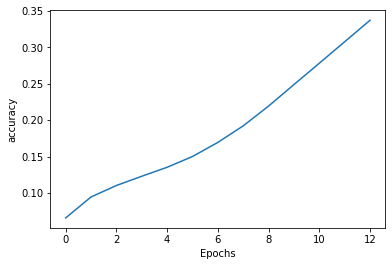

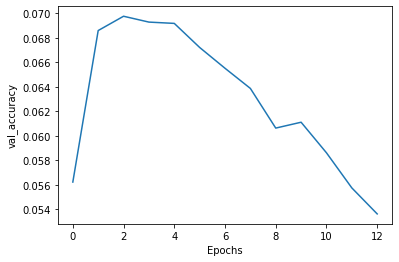

In [33]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'val_accuracy')


# Predictions

In [48]:
# these repeated import statements are unnecessary, just to show what one would need
# when running it in Flask
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np


seed_text = "dream cloud cheese" # edit this to generate new poems!
saved_model_path = 'f/content/drive/MyDrive/data/sortedmodel_tacc-{acc}_vacc-{vacc}_epochs-{epochs}'
loaded_model = tf.keras.models.load_model(saved_model_path)
tokenizer = pickle.load(open('/content/drive/MyDrive/data/tokenizer.pkl','rb'))
max_sequence_len=75 # make sure to edit this if it changes

def line_breaker(s):
	""" breaks string s into lines mostly randomly"""
	s = s.split()
	l=len(s) # len of string
	output=""
	while l>0:
		x=random.randint(1,int(l/2)+1)
		tmp = s[:x]
		output += ' '.join(tmp) + "\n"
		s=s[x:]
		l -= x
	# line breaking between repeated words
	split = output.split(' ')
	final = ""
	for i in range(len(split)-1):
		if split[i]==split[i+1]:
			final += split[i] + '\n'
		else: 
			final += split[i] + ' '
	if split[-2]==split[-1]:
		final += "\n"+split[-1]
	else:
		final +=split[-1]
	final_output = final[0].upper()+final[1:]
	return final_output  

def pred_poem(seed_text,next_words=30,incl_title=True,):
	og_seed = seed_text
	for _ in range(next_words):
		token_list = tokenizer.texts_to_sequences([seed_text])[0]
		token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
		predicted = np.argmax(loaded_model.predict(token_list), axis=-1)
		output_word = ""
		for word, index in tokenizer.word_index.items():
			if index == predicted:
				output_word = word
				break
		seed_text += " " + output_word
	if not incl_title:
		seed_text = seed_text[len(og_seed)+1:]
	return line_breaker(seed_text)

print(pred_poem(seed_text))

Dreams of cheese morsels run down
down to tummy with sabers we
delight
to
eat the
one
one of to the one and the one who
is not and
that subsides… and
yet

